In [1]:
import numpy as np
import pandas as pd
import geomstats.backend as gs
import matplotlib.pyplot as plt
import geomstats.datasets.utils as data_utils
from tqdm import tqdm
from geomstats.geometry.skew_symmetric_matrices import SkewSymmetricMatrices

In [2]:
x_train_df = pd.read_csv('/Users/reza/School/2025/1-Spring/Advanced ML/Project/data/new/preprocessed_selected_features/train/connectome_matrices.csv')
x_test_df = pd.read_csv('/Users/reza/School/2025/1-Spring/Advanced ML/Project/data/new/preprocessed_selected_features/test/connectome_matrices.csv')

In [ ]:
def process_single_row(atts):
    """
    Load brain connectome data and ADHD labels, returning symmetric matrices with ones on the diagonal.
    """
    atts = np.expand_dims(atts, axis=0)
    data = gs.array(atts)
    
    mat = SkewSymmetricMatrices(200).matrix_representation(data)
    mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
    
    matrix = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))
    eigenvalues = np.linalg.eigvals(matrix)
    min_eigenvalue = np.min(eigenvalues)

    if min_eigenvalue < 0:
        correction = -min_eigenvalue + 1e-6
        correction_matrix = correction * np.eye(matrix.shape[0])
        return (matrix + correction_matrix).astype(np.float32).flatten()
    else:
        return matrix.astype(np.float32).flatten()

In [ ]:
x = process_single_row(x_train_df.head(1).drop(['participant_id'], axis=1).iloc[0].values.astype(np.float32))

In [21]:
x.shape
x.min(), x.max()

(np.float32(-0.17776164), np.float32(1.3222383))

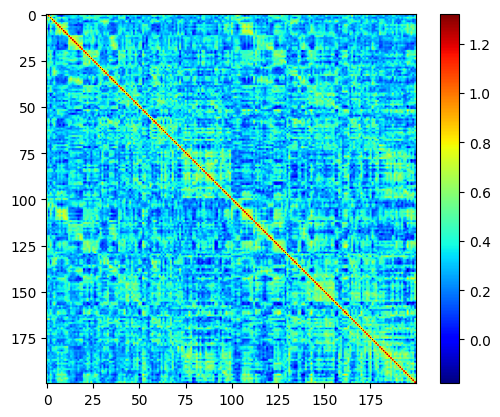

In [22]:
im = plt.imshow(x.reshape(200, 200), cmap='jet')
plt.colorbar(im)
plt.show()

In [6]:
x[0, 2, 2]

np.float32(1.3222383)

In [ ]:
def load_connectomes_row_by_row_with_progress(df_conn):
    """
    Wrapper function to process brain connectome data row by row and return the resulting DataFrame.
    Each row is processed using the process_single_row function. A progress bar is displayed for row processing.

    Parameters:
    - df_conn (DataFrame): DataFrame containing the connectome data, with 200 nodes and 'participant_id'.

    Returns:
    - result_df (DataFrame): DataFrame containing the processed skew-symmetric matrices, one row for each participant.
    """
    # Initialize a list to store the processed matrices
    processed_matrices = []

    # Initialize a list to store the participant ids
    participant_ids = []

    # Iterate over each row in the DataFrame with tqdm for progress bar
    for _, row in tqdm(
        df_conn.iterrows(), total=df_conn.shape[0], desc="Processing rows"
    ):
        # Extract the participant_id
        participant_id = row["participant_id"]
        participant_ids.append(participant_id)

        # Extract the edge attributes as a numpy array (excluding participant_id)
        edge_attributes = row.drop("participant_id").values.astype(np.float32)

        # Process the row using the process_single_row function
        processed_matrix = process_single_row(edge_attributes)

        # Append the processed matrix to the list
        processed_matrices.append(processed_matrix)

    # Convert the list of processed matrices into a DataFrame
    result_df = pd.DataFrame(processed_matrices)

    # Add the participant_id column back to the result DataFrame
    result_df["participant_id"] = participant_ids

    # Reorder the columns so that participant_id is the first column
    result_df = result_df[
        ["participant_id"]
        + [col for col in result_df.columns if col != "participant_id"]
    ]

    return result_df


# Example usage:
# Assuming df_conn is a DataFrame with 200 columns (for 200 nodes) and 'participant_id'
# corrected_df = load_connectomes_row_by_row_with_progress(df_conn)

In [24]:
xs = load_connectomes_row_by_row_with_progress(x_train_df.head(1))

Processing rows: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [25]:
x_new = xs.iloc[0].drop(['participant_id']).values

In [26]:
x_new = x_new.reshape(200, 200).astype(np.float32)

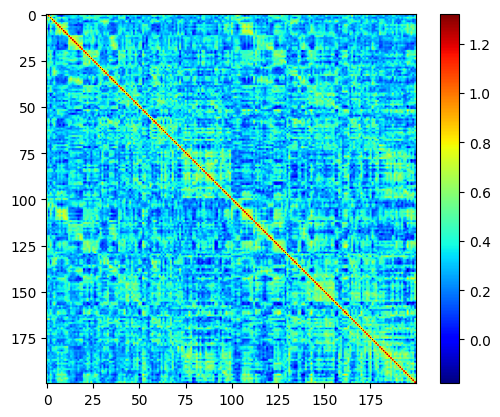

In [27]:
im = plt.imshow(x_new, cmap='jet')
plt.colorbar(im)
plt.show()

In [28]:
xs.head()

,participant_id,0,1,2,3,4,5,6,7,8,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,70z8Q2xdTXM3,1.322238,0.457438,0.612612,0.565184,0.354268,0.630888,0.490972,0.597353,0.278521,...,0.35194,0.179107,0.395365,0.111702,0.189087,0.436256,0.332089,0.584449,0.524383,1.322238
